# Swindon Elections

This script was written to provide easy interpretation of election statistics for Swindon. It has been initialised to load the data available [here](http://www.data.parliament.uk/dataset/elections/resource/e08217ef-8ded-49a9-941e-6b7cf1ddd2d7) The link allows an excel file to be downloaded. Additional population data was manually acquired and editied to provide population estimates each year from 2002-2019, this was available [here](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland).

I make no claim that this script is overly efficient, it was made for personal interest.

Any questions please contact:
> Andrew Paul Barnes<br>
> Doctoral Student & Teaching Assistant<br>
> Department of Architecture and Civil Engineering<br>
> University of Bath<br>
> a.p.barnes@bath.ac.uk

## Libraries

To begin several libraries are imported to allow easy manipulation of the data.

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from scipy.stats import linregress
from matplotlib.lines import Line2D

## Loading Data Required

First data is retrieved from the data.parliament.uk.

To begin the elections of North and South Swindon are extracted and stored.

In [2]:
def get_2010_onwards():
    """ Extracts the number of votes per party each year for North and South Swindon """
    eurl="http://lda.data.parliament.uk/electionresults.json?constituency.label={}+Swindon&exists-constituency.label=true&_view=Elections"
    curl="http://lda.data.parliament.uk/electionresults/{}.json"
    results = {}
    for constituency in ["North", "South"]:
        results[constituency] = {}
        elections = requests.get(eurl.format(constituency)).json()
        for election in elections['result']['items']:
            election_year = int(election['election']['label']['_value'][:4])
            e_result = requests.get(curl.format(election['_about'].split('/')[-1])).json()
            for candidate in e_result['result']['primaryTopic']['candidate']:
                party = candidate['party']['_value']
                if party in results[constituency]:
                    results[constituency][party][str(election_year)] = candidate['numberOfVotes']
                else:
                    results[constituency][party] = {str(election_year): candidate['numberOfVotes']}
    return results
results = get_2010_onwards()

Next let's load the manual population data.

In [3]:
def get_pop():
    population = np.loadtxt("population.csv", delimiter=',').T
    pop = {}
    for p in population:
        pop[str(int(p[0]))] = p[1]
    return pop
population = get_pop()

In [4]:
results

{'North': {'Con': {'2010': 22408, '2015': 26295, '2017': 29431, '2019': 32584},
  'Lab': {'2010': 15348, '2015': 14509, '2017': 21096, '2019': 16413},
  'LD': {'2010': 8668, '2015': 1704, '2017': 1962, '2019': 4408},
  'UKIP': {'2010': 1842, '2015': 8011, '2017': 1564},
  'BNP': {'2010': 1542},
  'Green': {'2010': 487, '2015': 1723, '2017': 858, '2019': 1710}},
 'South': {'Con': {'2010': 19687, '2015': 22777, '2017': 24809, '2019': 26536},
  'Lab': {'2010': 16143, '2015': 16992, '2017': 22345, '2019': 19911},
  'LD': {'2010': 8305, '2015': 1817, '2017': 2079, '2019': 4299},
  'UKIP': {'2010': 2029, '2015': 5920, '2017': 1291},
  'Green': {'2010': 619, '2015': 1757, '2017': 747},
  'Christian': {'2010': 176},
  'Ind': {'2010': 160}}}

Time to convert this into something useful and gather a collection of the parties, assigning them colours.

In [5]:
parties = {
    "Con": 'b',
    "Lab": 'r',
    "LD": 'orange',
    "UKIP": 'm',
    "Green": 'g',
    "BNP": 'c',
    "Christian": 'y',
    "Ind": 'k'
    
}
        
years = []
turnout = {}
for c in ["North", "South"]:
    for p in results[c]:
        #print(results[c][p])
        for y in results[c][p]:
            if y not in years:
                years.append(y)
                turnout[y] = results[c][p][y]
            else:
                turnout[y] = turnout[y] + results[c][p][y]

## Proportion of results

Stacked bar charts to show the proportion of resuts per year.

50295
52242
54911
55115
47119
49263
51271
50746


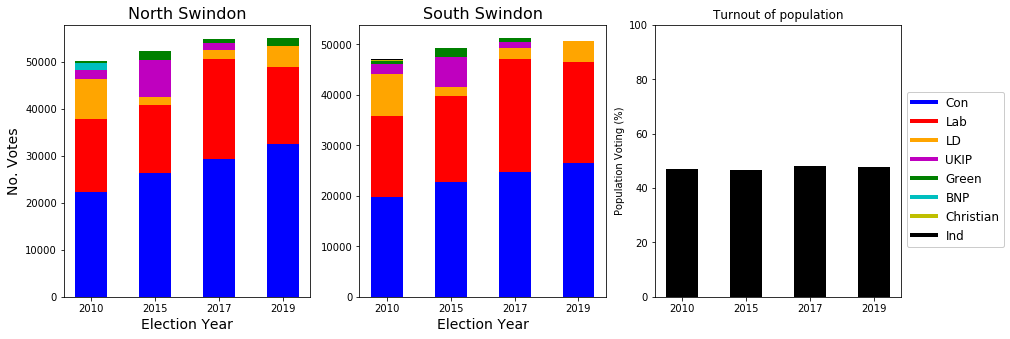

In [6]:
fig, all_axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

colours = ['m', 'r', 'g', 'b', 'c', 'y', 'k']
bar_width = 0.5

#ticks = [1, 9]
#labels = ["2011/2012", "2019/2020"]

for idx, c in enumerate(["North", "South"]):
    axs = all_axs[idx]
    for yidx, year in enumerate(years):
        height = 0
        for party in results[c]:
            if year in results[c][party]:
                axs.bar(year, results[c][party][year],
                                bar_width, bottom=height, color=parties[party])
                height = height + results[c][party][year]
        print(height)
    axs.set_title(c+" Swindon", fontsize=16)
    axs.set_xlabel("Election Year", fontsize=14)
    
all_axs[0].set_ylabel("No. Votes", fontsize=14)

for y in years:
    all_axs[-1].bar(y, (turnout[y]/population[y])*100, bar_width, bottom=0, color='k')
all_axs[-1].set_ylim([0, 100])
all_axs[-1].set_title("Turnout of population")
all_axs[-1].set_ylabel("Population Voting (%)")


bars = []
for p in parties:
    bars.append(Line2D([0], [0], color=parties[p], lw=4))

fig.legend(bars, parties.keys(),
                   loc="center right",
                   ncol=1, fontsize=12,
                   facecolor='w', framealpha=1)

In [7]:
z = 0
for y in years:
    z = z +(turnout[y]/population[y])*100
    print((turnout[y]/population[y])*100)
z/len(years)

47.073775363754535
46.6509485991617
48.185040138317234
47.64371514854203


47.38836981244387

In [8]:
z = 0
ys = [2010, 2015, 2017, 2019]
prev = 0
for idx in range(0, 4):
    print(
        results['North']['Con'][str(ys[idx])] / turnout[str(ys[idx])])

0.23002853799248568
0.25905127826215457
0.27717503908383717
0.30779985074767857


In [9]:
turnout[]

SyntaxError: invalid syntax (<ipython-input-9-1ae0d8776928>, line 1)

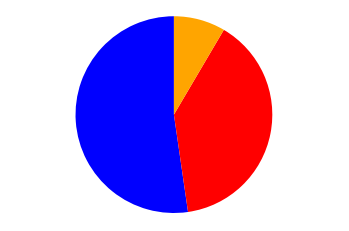

In [11]:
fig1, ax1 = plt.subplots()

colours = ['b', 'r', 'orange', 'm', 'g', 'k']

sizes = [
    26536,
    19911,
    4299
]

ax1.pie(sizes, colors=colours,
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()